In [ ]:
!pip install optuna PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import optuna
import yfinance as yf


from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score, explained_variance_score,r2_score,mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from pickle import TRUE
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [ ]:

# Tải dữ liệu chứng khoán từ yfinance (NĂM-THÁNG-NGÀY)
df = yf.download('SONY', start='2019-11-14', end='2024-11-14')

# Kiểm tra cấu trúc dữ liệu
print(df.head())

# Đổi tên các cột từ MultiIndex thành cột đơn giản
df.columns = df.columns.get_level_values('Price')

# Đặt lại tên cột để phù hợp với yêu cầu
df.reset_index(inplace=True)
df.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'}, inplace=True)

# Kiểm tra lại dữ liệu
print(df.head())

# Chuyển đổi cột 'date' sang định dạng ngày tháng
df['date'] = pd.to_datetime(df['date']).dt.date

# Hiển thị kết quả
print(df.head())



[*********************100%***********************]  1 of 1 completed

Price       Adj Close   Close    High     Low    Open   Volume
Ticker           SONY    SONY    SONY    SONY    SONY     SONY
Date                                                          
2019-11-14  11.272953  12.370  12.420  12.268  12.402  2120500
2019-11-15  11.311228  12.412  12.440  12.344  12.400  1626000
2019-11-18  11.380487  12.488  12.602  12.466  12.602  4135500
2019-11-19  11.282065  12.380  12.464  12.350  12.448  7562500
2019-11-20  11.205516  12.296  12.376  12.250  12.344  4262500
Price       date  adj_close   close    high     low    open   volume
0     2019-11-14  11.272953  12.370  12.420  12.268  12.402  2120500
1     2019-11-15  11.311228  12.412  12.440  12.344  12.400  1626000
2     2019-11-18  11.380487  12.488  12.602  12.466  12.602  4135500
3     2019-11-19  11.282065  12.380  12.464  12.350  12.448  7562500
4     2019-11-20  11.205516  12.296  12.376  12.250  12.344  4262500
Price        date  adj_close   close    high     low    open   volume
0      2019-

In [ ]:
# Chuyển cột date sang datetime
df['date'] = pd.to_datetime(df.date)
df.head()

Price,date,adj_close,close,high,low,open,volume
0,2019-11-14,11.272953,12.370,12.420,12.268,12.402,2120500
1,2019-11-15,11.311228,12.412,12.440,12.344,12.400,1626000
2,2019-11-18,11.380487,12.488,12.602,12.466,12.602,4135500
3,2019-11-19,11.282065,12.380,12.464,12.350,12.448,7562500
4,2019-11-20,11.205516,12.296,12.376,12.250,12.344,4262500


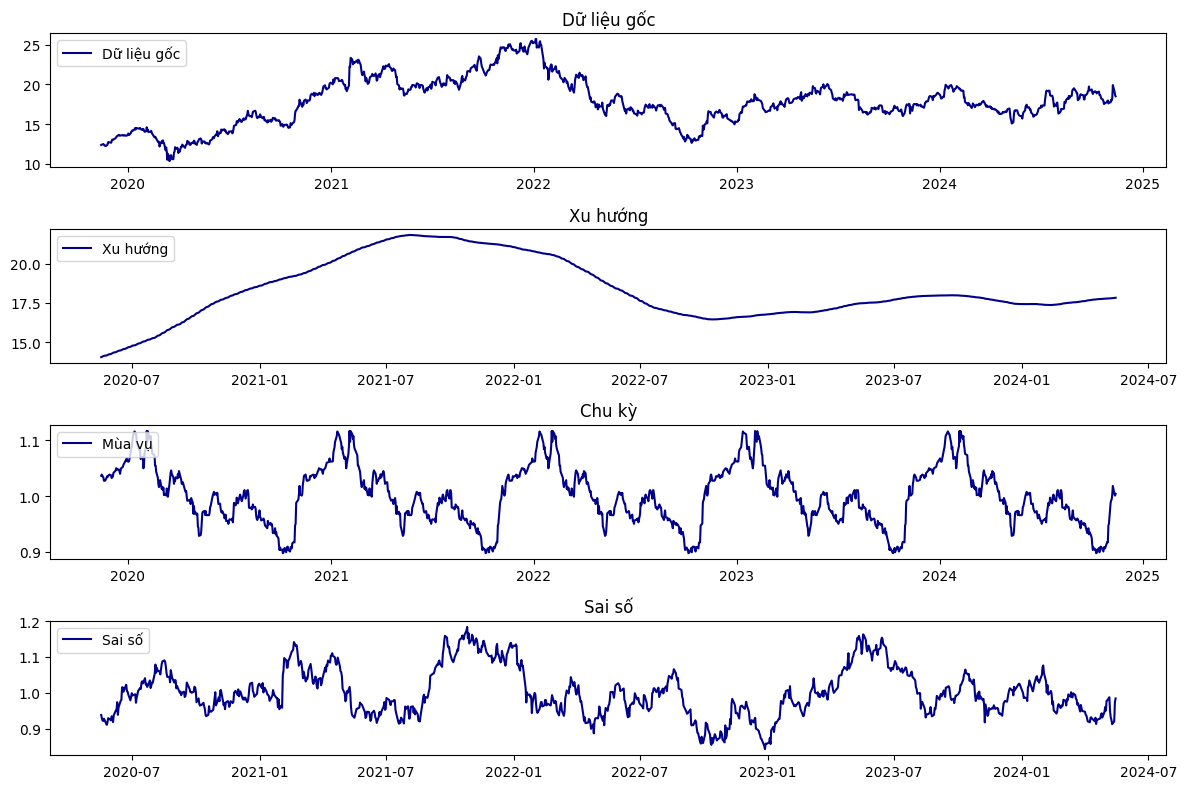

In [ ]:
# Giả sử df là DataFrame có cột 'date' và 'close'
closedfcopy = df[['date', 'close']].copy()

# Đặt cột 'date' làm chỉ mục (index)
closedfcopy['date'] = pd.to_datetime(closedfcopy['date'])
closedfcopy.set_index('date', inplace=True)

# Sử dụng phương pháp seasonal_decompose để phân tích chuỗi thời gian
# Chọn period phù hợp (ví dụ: 252 ngày giao dịch trong 1 năm)
result = seasonal_decompose(closedfcopy['close'], model='multiplicative', period=252)
# Vẽ biểu đồ các thành phần (xu hướng và chu kỳ)
plt.figure(figsize=(12, 8))

# Biểu đồ dữ liệu gốc
plt.subplot(4, 1, 1)
plt.plot(closedfcopy['close'], label='Dữ liệu gốc', color='darkblue')
plt.legend(loc='upper left')
plt.title('Dữ liệu gốc')

# Biểu đồ xu hướng (trend)
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Xu hướng', color='darkblue')
plt.legend(loc='upper left')
plt.title('Xu hướng')

# Biểu đồ mùa vụ (seasonality)
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Mùa vụ', color='darkblue')
plt.legend(loc='upper left')
plt.title('Chu kỳ')

# Biểu đồ residuals (Sai số)
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Sai số', color='darkblue')
plt.legend(loc='upper left')
plt.title('Sai số')

plt.tight_layout()
plt.show()

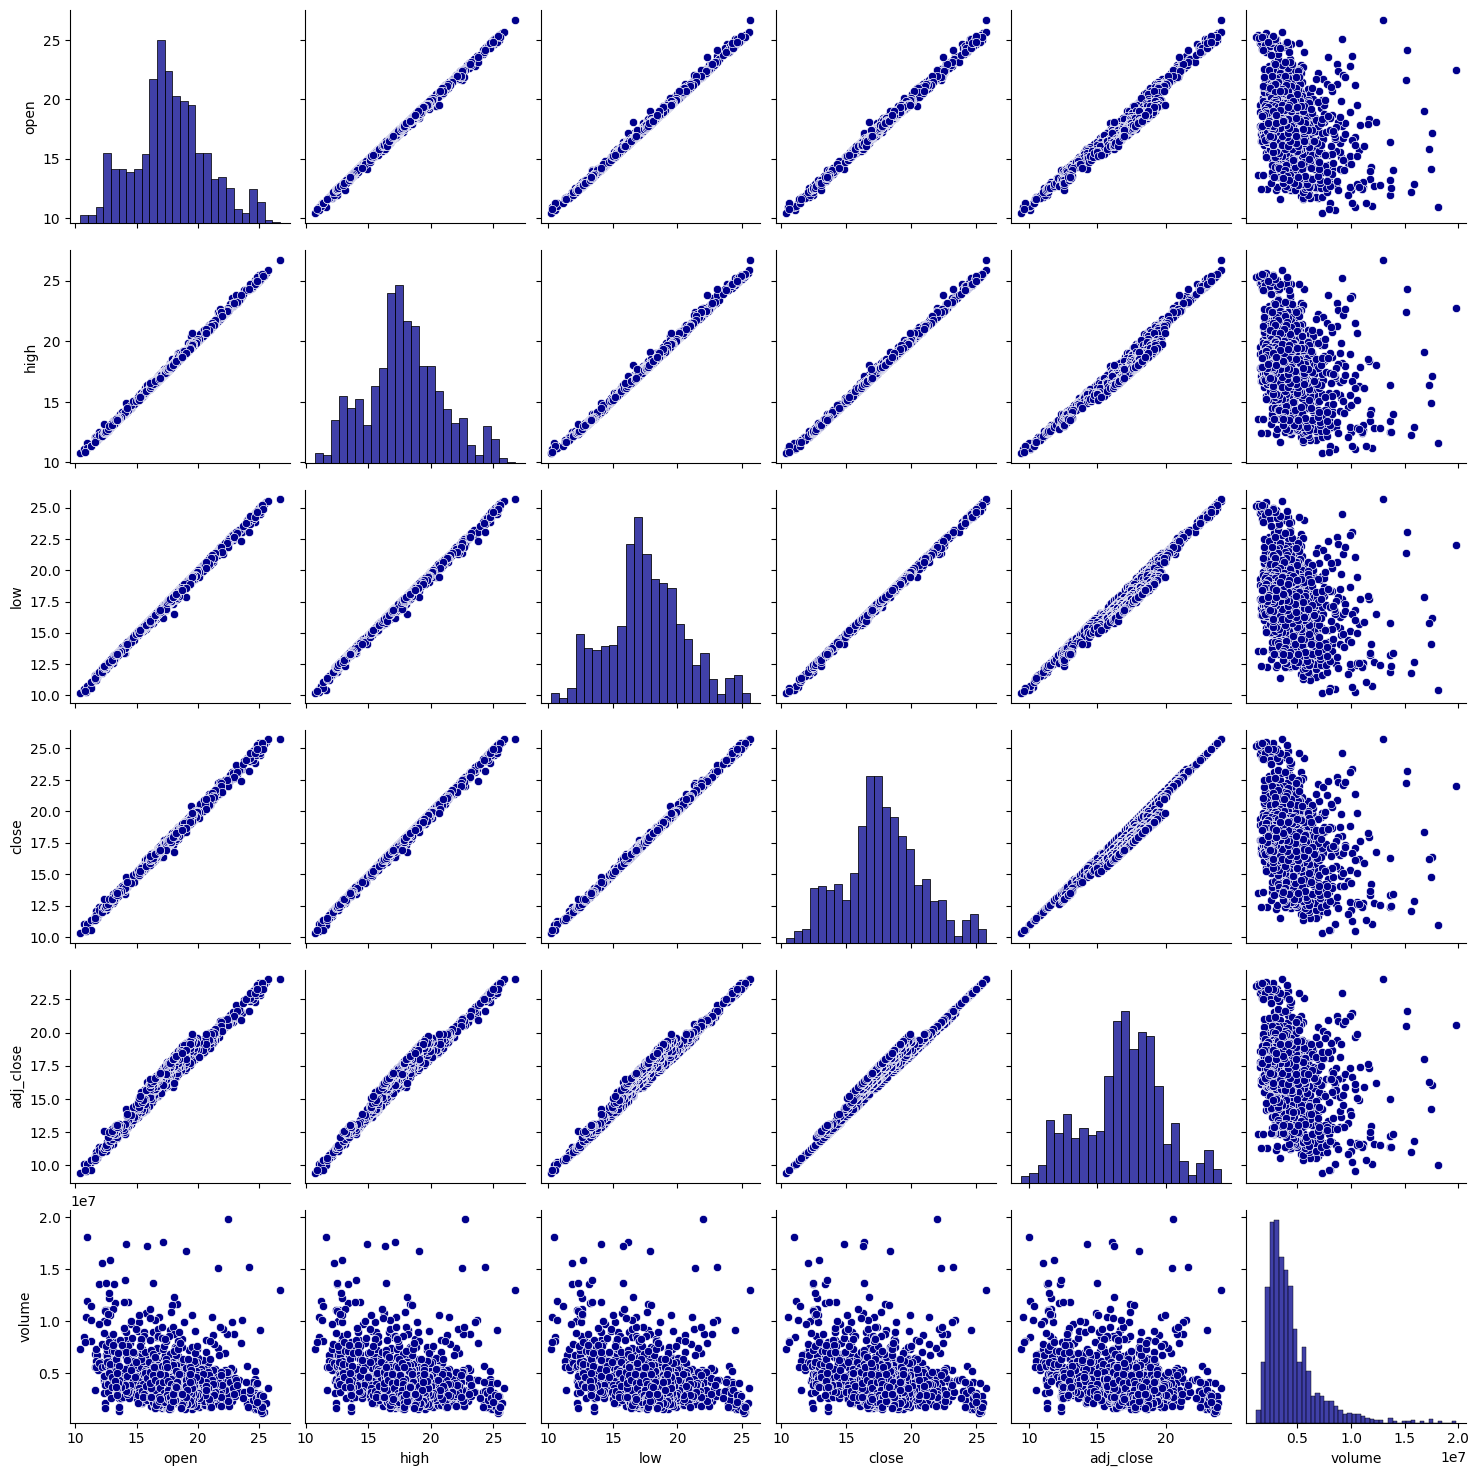

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử 'df' là DataFrame của bạn
# Chọn các cột bạn muốn hiển thị trong Pairplot (ví dụ: 'open', 'high', 'low', 'close', 'adj_close', 'volume')
cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Vẽ biểu đồ Pairplot với tất cả các yếu tố màu xanh
sns.pairplot(df[cols],
             plot_kws={'color': 'darkblue'},  # Màu cho biểu đồ phân tán
             diag_kws={'color': 'darkblue'})  # Màu cho histogram
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from datetime import datetime

def download_data(stock_symbol, start_date, end_date):
    """Tải dữ liệu cổ phiếu và thị trường, đảm bảo index đồng bộ."""
    try:
        # Tải dữ liệu cổ phiếu và thị trường
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        market_data = yf.download('^GSPC', start=start_date, end=end_date)

        # Kiểm tra dữ liệu rỗng
        if stock_data.empty or market_data.empty:
            raise ValueError(f"Dữ liệu không tìm thấy cho {stock_symbol}")

        # Chọn cột 'Adj Close' để sử dụng
        stock_data = stock_data['Adj Close']
        market_data = market_data['Adj Close']

        # Loại bỏ giá trị NaN và đồng bộ hóa index
        stock_data = stock_data.dropna()
        market_data = market_data.dropna()

        # Lấy các ngày chung giữa dữ liệu cổ phiếu và thị trường
        common_dates = stock_data.index.intersection(market_data.index)
        stock_data = stock_data.loc[common_dates]
        market_data = market_data.loc[common_dates]

        return stock_data, market_data

    except Exception as e:
        raise Exception(f"Lỗi khi tải dữ liệu: {str(e)}")


def calculate_returns(stock_data, market_data):
    """Tính toán lợi suất của cổ phiếu và thị trường."""
    # Tính lợi suất
    stock_returns = stock_data.pct_change().dropna()
    market_returns = market_data.pct_change().dropna()

    # Đồng bộ index giữa lợi suất cổ phiếu và thị trường
    common_dates = stock_returns.index.intersection(market_returns.index)
    stock_returns = stock_returns.loc[common_dates]
    market_returns = market_returns.loc[common_dates]

    return stock_returns, market_returns


def calculate_alpha_beta(stock_returns, market_returns):
    """Tính toán Alpha và Beta từ lợi suất cổ phiếu và thị trường."""
    # Thêm hằng số vào mô hình hồi quy
    X = sm.add_constant(market_returns)
    model = sm.OLS(stock_returns, X).fit()

    # Tính toán Alpha và Beta
    alpha = model.params.iloc[0] * 252  # Chuyển đổi sang giá trị hàng năm
    beta = model.params.iloc[1]  # Hệ số Beta
    return alpha, beta


def analyze_alpha_beta(stock_symbol, start_date):
    """Phân tích Alpha và Beta của một cổ phiếu."""
    print(f"\nPhân tích Alpha và Beta cho {stock_symbol}")
    print("=" * 50)

    # Lấy ngày hiện tại làm ngày kết thúc
    end_date = datetime.today().strftime('%Y-%m-%d')

    try:
        # Lấy dữ liệu cổ phiếu và thị trường
        stock_data, market_data = download_data(stock_symbol, start_date, end_date)

        # Tính toán lợi suất
        stock_returns, market_returns = calculate_returns(stock_data, market_data)

        # Tính toán Alpha và Beta
        alpha, beta = calculate_alpha_beta(stock_returns, market_returns)

        # Hiển thị Alpha và Beta
        print(f"Alpha: {alpha:.4f}")
        print(f"Beta: {beta:.4f}")

        # Phân tích Alpha
        if alpha > 0:
            print(f"- Alpha dương ({alpha:.4f}): Cổ phiếu có hiệu suất vượt trội so với thị trường.")
            if alpha > 0.05:
                print("  → Hiệu suất vượt trội đáng kể.")
        else:
            print(f"- Alpha âm ({alpha:.4f}): Cổ phiếu có hiệu suất kém hơn so với thị trường.")

        # Phân tích Beta
        if beta > 1.2:
            print(f"- Beta cao ({beta:.4f}): Cổ phiếu có độ biến động rất lớn so với thị trường.")
        elif beta > 1:
            print(f"- Beta trung bình cao ({beta:.4f}): Cổ phiếu có độ biến động cao hơn thị trường.")
        elif beta < 0.8:
            print(f"- Beta thấp ({beta:.4f}): Cổ phiếu có độ biến động thấp hơn thị trường.")
        else:
            print(f"- Beta trung bình thấp ({beta:.4f}): Cổ phiếu có độ biến động tương đương thị trường.")

    except Exception as e:
        print(f"Lỗi khi phân tích {stock_symbol}: {str(e)}")


# Sử dụng hàm với một danh sách các cổ phiếu
tickers = ['MSFT']  # Danh sách mã cổ phiếu
start_date = '2019-11-14'  # Ngày bắt đầu

for ticker in tickers:
    analyze_alpha_beta(ticker, start_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Phân tích Alpha và Beta cho MSFT
Alpha: 0.0916
Beta: 1.1749
- Alpha dương (0.0916): Cổ phiếu có hiệu suất vượt trội so với thị trường.
  → Hiệu suất vượt trội đáng kể.
- Beta trung bình cao (1.1749): Cổ phiếu có độ biến động cao hơn thị trường.


Nhập mã cổ phiếu (ví dụ: AAPL): MSFT


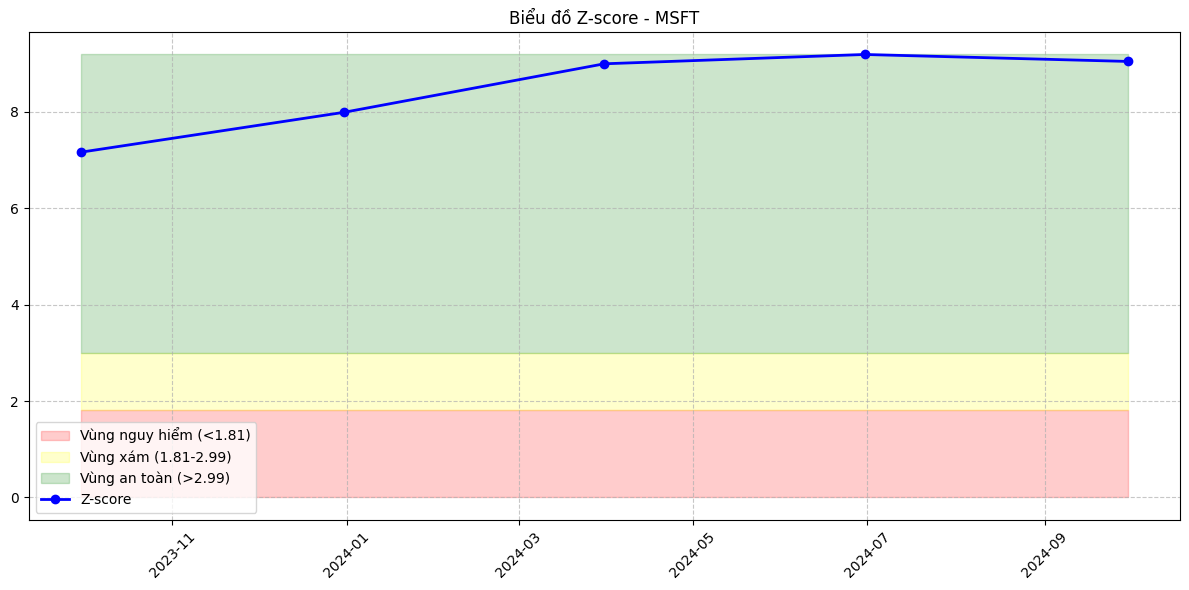


BÁO CÁO PHÂN TÍCH Z-SCORE - MSFT
Ngày phân tích: 2024-12-14 07:26:03

Z-score mới nhất (2024-09-30): 9.05
Đánh giá: VÙNG AN TOÀN - Tình hình tài chính tốt

Lịch sử Z-score theo quý:
              zscore
2023-09-30  7.162907
2023-12-31  7.990157
2024-03-31  8.996364
2024-06-30  9.189517
2024-09-30  9.045448


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz

class PhanTichTaiChinh:
    def __init__(self, ma_co_phieu: str):
        self.ma_co_phieu = ma_co_phieu
        self.stock = yf.Ticker(ma_co_phieu)

    def tinh_zscore(self, so_quy: int = 8):
        """Tính Z-score cho số quý chỉ định"""
        try:
            # Lấy dữ liệu báo cáo tài chính
            balance_sheet = self.stock.quarterly_balance_sheet
            income_stmt = self.stock.quarterly_income_stmt

            if balance_sheet is None or income_stmt is None or balance_sheet.empty or income_stmt.empty:
                raise ValueError("Không tìm thấy dữ liệu báo cáo tài chính")

            # Lấy dữ liệu giá và số lượng cổ phiếu
            end_date = datetime.now(pytz.UTC)
            start_date = end_date - timedelta(days=so_quy * 100)
            stock_data = self.stock.history(start=start_date, end=end_date)

            if stock_data.empty:
                raise ValueError("Không tìm thấy dữ liệu giá cổ phiếu")

            shares = self.stock.info.get('sharesOutstanding', 0)
            if shares <= 0:
                raise ValueError("Không tìm thấy số lượng cổ phiếu hợp lệ")

            # Lấy các ngày có đủ dữ liệu
            dates = sorted(set(balance_sheet.columns) & set(income_stmt.columns))
            if len(dates) < so_quy:
                raise ValueError(f"Không đủ dữ liệu cho {so_quy} quý gần nhất")
            dates = dates[-so_quy:]

            results = pd.DataFrame(index=dates, columns=['zscore'])

            for date in dates:
                # Lấy dữ liệu tài chính với xử lý giá trị None
                def get_value(df, row_name, date):
                    try:
                        return float(df.loc[row_name, date]) if row_name in df.index else 0
                    except:
                        return 0

                total_assets = get_value(balance_sheet, 'Total Assets', date)
                if total_assets <= 0:
                    continue

                current_assets = get_value(balance_sheet, 'Current Assets', date)
                current_liab = get_value(balance_sheet, 'Current Liabilities', date)
                total_liab = get_value(balance_sheet, 'Total Liabilities Net Minority Interest', date)
                retained_earnings = get_value(balance_sheet, 'Retained Earnings', date)
                ebit = get_value(income_stmt, 'Operating Income', date)
                revenue = get_value(income_stmt, 'Total Revenue', date)

                # Tính market cap
                date_utc = pd.to_datetime(date).tz_localize(pytz.UTC)
                nearest_date = min(stock_data.index, key=lambda x: abs(x - date_utc))
                market_cap = float(stock_data.loc[nearest_date, 'Close']) * shares

                # Tính các thành phần Z-score
                X1 = (current_assets - current_liab) / total_assets
                X2 = retained_earnings / total_assets
                X3 = ebit / total_assets
                X4 = min(market_cap / total_liab if total_liab != 0 else 0, 20.0)
                X5 = revenue / total_assets

                zscore = 1.2 * X1 + 1.4 * X2 + 3.3 * X3 + 0.6 * X4 + 1.0 * X5

                if not np.isnan(zscore) and not np.isinf(zscore):
                    results.loc[date, 'zscore'] = zscore

            if results.empty or results['zscore'].isna().all():
                raise ValueError("Không thể tính được Z-score cho bất kỳ quý nào")

            return results.dropna()

        except Exception as e:
            raise Exception(f"Lỗi khi tính Z-score: {str(e)}")

    def danh_gia_zscore(self, zscore: float) -> str:
        """Đánh giá tình trạng dựa trên Z-score"""
        if zscore < 1.81:
            return "VÙNG NGUY HIỂM - Nguy cơ phá sản cao"
        elif zscore < 2.99:
            return "VÙNG XÁM - Cần theo dõi chặt chẽ"
        else:
            return "VÙNG AN TOÀN - Tình hình tài chính tốt"

    def ve_bieu_do(self, data: pd.DataFrame):
        """Vẽ biểu đồ Z-score"""
        plt.figure(figsize=(12, 6))

        # Vẽ các vùng cảnh báo
        plt.fill_between(data.index, 0, 1.81, color='red', alpha=0.2, label='Vùng nguy hiểm (<1.81)')
        plt.fill_between(data.index, 1.81, 2.99, color='yellow', alpha=0.2, label='Vùng xám (1.81-2.99)')
        plt.fill_between(data.index, 2.99, max(6, data['zscore'].max()),
                        color='green', alpha=0.2, label='Vùng an toàn (>2.99)')

        # Vẽ đường Z-score
        plt.plot(data.index, data['zscore'], 'b-o', linewidth=2, label='Z-score')

        plt.title(f'Biểu đồ Z-score - {self.ma_co_phieu}')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def tao_bao_cao(self, so_quy: int = 5) -> str:
        """Tạo báo cáo phân tích"""
        try:
            data = self.tinh_zscore(so_quy)
            latest_zscore = data['zscore'].iloc[-1]
            latest_date = data.index[-1].strftime('%Y-%m-%d')

            # Tạo báo cáo
            report = [
                f"\nBÁO CÁO PHÂN TÍCH Z-SCORE - {self.ma_co_phieu}",
                f"Ngày phân tích: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
                f"\nZ-score mới nhất ({latest_date}): {latest_zscore:.2f}",
                f"Đánh giá: {self.danh_gia_zscore(latest_zscore)}",
                "\nLịch sử Z-score theo quý:",
                str(data.round(2))
            ]

            # Vẽ biểu đồ
            self.ve_bieu_do(data)

            return "\n".join(report)

        except Exception as e:
            raise Exception(f"Lỗi khi tạo báo cáo: {str(e)}")

def main():
    try:
        ma_co_phieu = input("Nhập mã cổ phiếu (ví dụ: AAPL): ").strip().upper()
        phan_tich = PhanTichTaiChinh(ma_co_phieu)
        print(phan_tich.tao_bao_cao())
    except Exception as e:
        print(f"Lỗi: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
import yfinance as yf
from typing import Dict, Optional, Tuple
import pandas as pd
from datetime import datetime
import pytz

class PhanTichTaiChinh:
    def __init__(self, ma_co_phieu: str):
        """
        Khởi tạo công cụ Phân Tích Tài Chính với mã cổ phiếu.

        Tham số:
            ma_co_phieu (str): Mã cổ phiếu (ví dụ: 'AAPL')
        """
        self.ma_co_phieu = ma_co_phieu
        self.co_phieu = yf.Ticker(ma_co_phieu)

        # Lấy dữ liệu theo quý để có thông tin mới nhất
        self.bao_cao_tai_chinh = self.co_phieu.quarterly_financials
        self.bang_can_doi = self.co_phieu.quarterly_balance_sheet
        self.bao_cao_thu_nhap = self.co_phieu.quarterly_income_stmt

        # Kiểm tra dữ liệu hợp lệ
        if not self._kiem_tra_du_lieu():
            raise ValueError(f"Không tìm thấy đủ dữ liệu cho mã {ma_co_phieu}")

    def _kiem_tra_du_lieu(self) -> bool:
        """
        Kiểm tra tính hợp lệ của dữ liệu.
        """
        return (
            self.bao_cao_tai_chinh is not None and
            not self.bao_cao_tai_chinh.empty and
            self.bang_can_doi is not None and
            not self.bang_can_doi.empty and
            self.bao_cao_thu_nhap is not None and
            not self.bao_cao_thu_nhap.empty
        )

    def lay_gia_tri_an_toan(self, dataframe: pd.DataFrame, chi_so: str, mac_dinh: float = 0.0) -> float:
        """
        Lấy giá trị từ DataFrame một cách an toàn.

        Tham số:
            dataframe: DataFrame chứa dữ liệu
            chi_so: Tên chỉ số cần lấy
            mac_dinh: Giá trị mặc định nếu không tìm thấy
        """
        try:
            if chi_so in dataframe.index:
                gia_tri = dataframe.loc[chi_so].iloc[0]  # Sửa ở đây, dùng iloc[0] thay cho [0]
                return float(gia_tri) if pd.notnull(gia_tri) else mac_dinh
            return mac_dinh
        except Exception:
            return mac_dinh

    def tinh_roa(self) -> Tuple[Optional[float], Optional[Dict]]:
        """
        Tính tỷ suất sinh lời trên tài sản (ROA) với dữ liệu mới nhất.
        """
        try:
            # Lấy thời điểm của dữ liệu mới nhất
            ky_bao_cao = self.bao_cao_tai_chinh.columns[0]

            # Lấy các giá trị cần thiết
            loi_nhuan_rong = self.lay_gia_tri_an_toan(self.bao_cao_thu_nhap, 'Net Income')
            tong_tai_san = self.lay_gia_tri_an_toan(self.bang_can_doi, 'Total Assets')
            doanh_thu = self.lay_gia_tri_an_toan(self.bao_cao_thu_nhap, 'Total Revenue')
            loi_nhuan_hoat_dong = self.lay_gia_tri_an_toan(self.bao_cao_thu_nhap, 'Operating Income')

            if tong_tai_san == 0:
                return None, None

            roa = loi_nhuan_rong / tong_tai_san

            chi_tiet = {
                'loi_nhuan_rong': loi_nhuan_rong,
                'tong_tai_san': tong_tai_san,
                'doanh_thu': doanh_thu,
                'loi_nhuan_hoat_dong': loi_nhuan_hoat_dong,
                'ky_bao_cao': ky_bao_cao.strftime('%d-%m-%Y'),
                'bien_loi_nhuan': (loi_nhuan_rong / doanh_thu) if doanh_thu != 0 else 0,
                'vong_quay_tai_san': (doanh_thu / tong_tai_san) if tong_tai_san != 0 else 0
            }

            return roa, chi_tiet

        except Exception as e:
            print(f"Lỗi khi tính ROA: {str(e)}")
            return None, None

    def dinh_dang_so(self, so: float) -> str:
        """
        Định dạng số tiền với đơn vị phù hợp.
        """
        if abs(so) >= 1e12:
            return f"{so/1e12:.2f} nghìn tỷ"
        elif abs(so) >= 1e9:
            return f"{so/1e9:.2f} tỷ"
        elif abs(so) >= 1e6:
            return f"{so/1e6:.2f} triệu"
        else:
            return f"{so:,.2f}"

    def tao_bao_cao(self) -> str:
        """
        Tạo báo cáo phân tích tài chính chi tiết.
        """
        roa, chi_tiet = self.tinh_roa()

        if roa is None or chi_tiet is None:
            return "Không thể tạo báo cáo do thiếu dữ liệu tài chính."

        bao_cao = f"""
BÁO CÁO PHÂN TÍCH TÀI CHÍNH - {self.ma_co_phieu}
Kỳ báo cáo: {chi_tiet['ky_bao_cao']}

1. Chỉ số ROA (Tỷ suất sinh lời trên tài sản):
   - Giá trị ROA: {roa:.4%}
   - Biên lợi nhuận: {chi_tiet['bien_loi_nhuan']:.4%}
   - Vòng quay tài sản: {chi_tiet['vong_quay_tai_san']:.2f} lần

2. Các chỉ tiêu tài chính:
   - Doanh thu: {self.dinh_dang_so(chi_tiet['doanh_thu'])} VND
   - Lợi nhuận hoạt động: {self.dinh_dang_so(chi_tiet['loi_nhuan_hoat_dong'])} VND
   - Lợi nhuận ròng: {self.dinh_dang_so(chi_tiet['loi_nhuan_rong'])} VND
   - Tổng tài sản: {self.dinh_dang_so(chi_tiet['tong_tai_san'])} VND

Đánh giá:
- Hiệu quả sử dụng tài sản: {self._danh_gia_roa(roa)}
- Mỗi 100 đồng tài sản tạo ra {(roa*100):.2f} đồng lợi nhuận ròng
"""
        return bao_cao

    def _danh_gia_roa(self, roa: float) -> str:
        """
        Đánh giá chỉ số ROA.
        """
        if roa >= 0.20:
            return "Rất tốt"
        elif roa >= 0.10:
            return "Tốt"
        elif roa >= 0.05:
            return "Trung bình"
        elif roa > 0:
            return "Thấp"
        else:
            return "Không hiệu quả"

def main():
    try:
        ma_co_phieu = input("Nhập mã cổ phiếu (ví dụ: AAPL): ").strip().upper()
        phan_tich = PhanTichTaiChinh(ma_co_phieu)
        print(phan_tich.tao_bao_cao())
    except Exception as e:
        print(f"Lỗi: {str(e)}")

if __name__ == "__main__":
    main()

Nhập mã cổ phiếu (ví dụ: AAPL): AAPL

BÁO CÁO PHÂN TÍCH TÀI CHÍNH - AAPL
Kỳ báo cáo: 30-09-2024

1. Chỉ số ROA (Tỷ suất sinh lời trên tài sản):
   - Giá trị ROA: 4.0375%
   - Biên lợi nhuận: 15.5230%
   - Vòng quay tài sản: 0.26 lần

2. Các chỉ tiêu tài chính:
   - Doanh thu: 94.93 tỷ VND
   - Lợi nhuận hoạt động: 29.59 tỷ VND
   - Lợi nhuận ròng: 14.74 tỷ VND
   - Tổng tài sản: 364.98 tỷ VND

Đánh giá:
- Hiệu quả sử dụng tài sản: Thấp
- Mỗi 100 đồng tài sản tạo ra 4.04 đồng lợi nhuận ròng



In [ ]:
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from typing import Dict, Optional, Tuple
from datetime import datetime
import pandas as pd
import pytz

class PhanTichDinhGia:
    def __init__(self, ma_co_phieu: str):
        """
        Khởi tạo công cụ phân tích định giá cổ phiếu

        Args:
            ma_co_phieu (str): Mã cổ phiếu (VD: AAPL, MSFT)
        """
        self.ma_co_phieu = ma_co_phieu
        self.co_phieu = yf.Ticker(ma_co_phieu)
        self.thoi_diem_cap_nhat = None
        self._cap_nhat_du_lieu()

    def _cap_nhat_du_lieu(self) -> bool:
        """
        Cập nhật dữ liệu cơ bản của cổ phiếu

        Returns:
            bool: True nếu cập nhật thành công, False nếu thất bại
        """
        try:
            # Lấy thông tin cơ bản
            self.thong_tin = self.co_phieu.info
            if not self.thong_tin:
                print(f"Không tìm thấy thông tin cho mã {self.ma_co_phieu}")
                return False

            # Lấy báo cáo tài chính theo quý mới nhất
            self.bang_can_doi = self.co_phieu.quarterly_balance_sheet
            self.bao_cao_thu_nhap = self.co_phieu.quarterly_financials

            if self.bang_can_doi is None or self.bang_can_doi.empty:
                print("Không tìm thấy dữ liệu bảng cân đối kế toán")
                return False

            # Lấy giá và lịch sử giao dịch
            lich_su = self.co_phieu.history(period="1d")
            if not lich_su.empty:
                self.gia_hien_tai = lich_su['Close'][-1]
                self.thoi_diem_cap_nhat = datetime.now(pytz.UTC)
            else:
                print("Không lấy được giá hiện tại")
                return False

            self.lich_su_gia = self.co_phieu.history(period="1y")
            return True

        except Exception as e:
            print(f"Lỗi khi cập nhật dữ liệu: {str(e)}")
            return False

    def refresh(self) -> bool:
        """
        Làm mới dữ liệu

        Returns:
            bool: True nếu làm mới thành công
        """
        return self._cap_nhat_du_lieu()

    def lay_gia_tri_an_toan(self, dataframe: pd.DataFrame, chi_so: str, mac_dinh: float = None) -> Optional[float]:
        """
        Lấy giá trị từ DataFrame một cách an toàn
        """
        try:
            if dataframe is not None and not dataframe.empty and chi_so in dataframe.index:
                gia_tri = dataframe.loc[chi_so][0]
                return float(gia_tri) if pd.notnull(gia_tri) else mac_dinh
            return mac_dinh
        except Exception:
            return mac_dinh

    def tinh_pe_ratio(self) -> Tuple[Optional[float], str, Dict]:
        """
        Tính và đánh giá chỉ số P/E

        Returns:
            Tuple[Optional[float], str, Dict]: (P/E ratio, Đánh giá, Chi tiết)
        """
        chi_tiet = {
            'eps': None,
            'gia': self.gia_hien_tai,
            'ngay_bao_cao': None
        }

        try:
            # Lấy EPS từ báo cáo thu nhập mới nhất
            eps_quy = self.lay_gia_tri_an_toan(
                self.bao_cao_thu_nhap,
                'Basic EPS',
                self.thong_tin.get('epsTrailingTwelveMonths')
            )

            if eps_quy and eps_quy != 0:
                chi_tiet['eps'] = eps_quy
                chi_tiet['ngay_bao_cao'] = self.bao_cao_thu_nhap.columns[0]

                pe = self.gia_hien_tai / eps_quy
                danh_gia = self._danh_gia_pe(pe)
                return pe, danh_gia, chi_tiet

        except Exception as e:
            print(f"Lỗi khi tính P/E: {str(e)}")

        return None, "Không có đủ dữ liệu để tính P/E", chi_tiet

    def tinh_pb_ratio(self) -> Tuple[Optional[float], str, Dict]:
        """
        Tính và đánh giá chỉ số P/B

        Returns:
            Tuple[Optional[float], str, Dict]: (P/B ratio, Đánh giá, Chi tiết)
        """
        chi_tiet = {
            'so_cp': None,
            'tai_san': None,
            'no': None,
            'gtss': None,
            'ngay_bao_cao': None
        }

        try:
            so_cp = self.thong_tin.get('sharesOutstanding')
            if not so_cp:
                return None, "Không có thông tin số cổ phiếu", chi_tiet

            tai_san = self.lay_gia_tri_an_toan(self.bang_can_doi, 'Total Assets')
            no = self.lay_gia_tri_an_toan(self.bang_can_doi, 'Total Liabilities Net Minority Interest')

            if tai_san is None or no is None:
                return None, "Thiếu dữ liệu tài sản hoặc nợ", chi_tiet

            chi_tiet.update({
                'so_cp': so_cp,
                'tai_san': tai_san,
                'no': no,
                'ngay_bao_cao': self.bang_can_doi.columns[0]
            })

            gtss = (tai_san - no) / so_cp
            chi_tiet['gtss'] = gtss

            if gtss <= 0:
                return None, "Giá trị sổ sách âm hoặc bằng 0", chi_tiet

            pb = self.gia_hien_tai / gtss
            danh_gia = self._danh_gia_pb(pb)
            return pb, danh_gia, chi_tiet

        except Exception as e:
            print(f"Lỗi khi tính P/B: {str(e)}")
            return None, f"Lỗi khi tính P/B: {str(e)}", chi_tiet

    def _danh_gia_pe(self, pe: float) -> str:
        """Đánh giá chi tiết chỉ số P/E"""
        if pe <= 0:
            return "P/E âm, công ty đang lỗ"
        elif pe < 10:
            return "P/E thấp, có thể được định giá thấp hoặc có rủi ro"
        elif pe < 20:
            return "P/E ở mức hợp lý, phù hợp với doanh nghiệp trưởng thành"
        elif pe < 30:
            return "P/E cao, thị trường kỳ vọng tăng trưởng mạnh"
        else:
            return "P/E rất cao, cần thận trọng với kỳ vọng của thị trường"

    def _danh_gia_pb(self, pb: float) -> str:
        """Đánh giá chi tiết chỉ số P/B"""
        if pb < 1:
            return "P/B dưới 1, có thể định giá thấp hoặc có vấn đề về tài chính"
        elif pb < 2:
            return "P/B ở mức hợp lý cho doanh nghiệp trưởng thành"
        elif pb < 3:
            return "P/B tương đối cao, thị trường định giá tốt"
        else:
            return "P/B cao, phản ánh kỳ vọng cao hoặc lợi thế cạnh tranh mạnh"

    def tinh_ty_suat_co_tuc(self) -> Tuple[Optional[float], Dict]:
        """
        Tính tỷ suất cổ tức và thông tin chi tiết
        """
        chi_tiet = {
            'co_tuc_hang_nam': None,
            'ty_le_chi_tra': None,
            'ngay_co_tuc_gan_nhat': None
        }

        try:
            ty_suat = self.thong_tin.get('dividendYield', 0) * 100
            chi_tiet.update({
                'co_tuc_hang_nam': self.thong_tin.get('dividendRate'),
                'ty_le_chi_tra': self.thong_tin.get('payoutRatio'),
                'ngay_co_tuc_gan_nhat': self.thong_tin.get('lastDividendDate')
            })
            return ty_suat, chi_tiet
        except Exception:
            return None, chi_tiet

    def dinh_dang_so(self, so: float) -> str:
        """
        Định dạng số cho dễ đọc
        """
        if so is None:
            return "N/A"
        if abs(so) >= 1e9:
            return f"{so/1e9:.2f} tỷ"
        elif abs(so) >= 1e6:
            return f"{so/1e6:.2f} triệu"
        else:
            return f"{so:,.2f}"

    def tao_bao_cao(self) -> str:
        """Tạo báo cáo phân tích tổng hợp"""
        if not self.thoi_diem_cap_nhat:
            return "Chưa có dữ liệu. Vui lòng thử lại."

        pe, danh_gia_pe, chi_tiet_pe = self.tinh_pe_ratio()
        pb, danh_gia_pb, chi_tiet_pb = self.tinh_pb_ratio()
        ty_suat_co_tuc, chi_tiet_co_tuc = self.tinh_ty_suat_co_tuc()
        beta = self.thong_tin.get('beta')

        bao_cao = f"""
BÁO CÁO PHÂN TÍCH ĐỊNH GIÁ - {self.ma_co_phieu}
Thời điểm cập nhật: {self.thoi_diem_cap_nhat.strftime('%d/%m/%Y %H:%M:%S')}
Giá hiện tại: {self.dinh_dang_so(self.gia_hien_tai)}

1. Chỉ số P/E:
   - Giá trị: {f"{pe:.2f}" if pe else "N/A"}
   - EPS: {self.dinh_dang_so(chi_tiet_pe['eps'])}
   - Kỳ báo cáo: {chi_tiet_pe['ngay_bao_cao'].strftime('%d/%m/%Y') if chi_tiet_pe['ngay_bao_cao'] else 'N/A'}
   - Đánh giá: {danh_gia_pe}

2. Chỉ số P/B:
   - Giá trị: {f"{pb:.2f}" if pb else "N/A"}
   - Giá trị sổ sách/CP: {self.dinh_dang_so(chi_tiet_pb['gtss'])}
   - Kỳ báo cáo: {chi_tiet_pb['ngay_bao_cao'].strftime('%d/%m/%Y') if chi_tiet_pb['ngay_bao_cao'] else 'N/A'}
   - Đánh giá: {danh_gia_pb}

3. Thông tin cổ tức:
   - Tỷ suất: {f"{ty_suat_co_tuc:.2f}%" if ty_suat_co_tuc else "Không có"}
   - Cổ tức/năm: {self.dinh_dang_so(chi_tiet_co_tuc['co_tuc_hang_nam'])}
   - Tỷ lệ chi trả: {f"{chi_tiet_co_tuc['ty_le_chi_tra']*100:.2f}%" if chi_tiet_co_tuc['ty_le_chi_tra'] else "N/A"}

4. Độ biến động (Beta): {f"{beta:.2f}" if beta else "N/A"}
   {f"-> Độ biến động {'cao' if beta > 1 else 'thấp'} hơn thị trường" if beta else ""}
"""
        return bao_cao

def main():
    try:
        ma_co_phieu = input("Nhập mã cổ phiếu (VD: AAPL, MSFT): ").strip().upper()
        phan_tich = PhanTichDinhGia(ma_co_phieu)
        print(phan_tich.tao_bao_cao())
    except Exception as e:
        print(f"Lỗi: {str(e)}")

if __name__ == "__main__":
    main()

Nhập mã cổ phiếu (VD: AAPL, MSFT): MSFT

BÁO CÁO PHÂN TÍCH ĐỊNH GIÁ - MSFT
Thời điểm cập nhật: 14/12/2024 06:26:56
Giá hiện tại: 447.27

1. Chỉ số P/E:
   - Giá trị: 134.72
   - EPS: 3.32
   - Kỳ báo cáo: 30/09/2024
   - Đánh giá: P/E rất cao, cần thận trọng với kỳ vọng của thị trường

2. Chỉ số P/B:
   - Giá trị: 11.56
   - Giá trị sổ sách/CP: 38.70
   - Kỳ báo cáo: 30/09/2024
   - Đánh giá: P/B cao, phản ánh kỳ vọng cao hoặc lợi thế cạnh tranh mạnh

3. Thông tin cổ tức:
   - Tỷ suất: 0.74%
   - Cổ tức/năm: 3.32
   - Tỷ lệ chi trả: 24.77%

4. Độ biến động (Beta): 0.90
   -> Độ biến động thấp hơn thị trường

